In [ ]:
# This code block configures things for google colab
! pip install git+https://github.com/shchurch/countland.git\#egg=countland\&subdirectory=countland-py
! git clone https://github.com/shchurch/countland.git

**note: in google colab, you must restart the runtime after running the above block**

# countland: python tutorial
**Samuel H. Church, Casey W. Dunn**

### Samuel H. Church

url: https://github.com/shchurch/countland/countland-py/vignettes/vignette_tutorial.ipynb

This tutorial demonstrates the major functions of `countland` by applying them to a Gold standard single-cell RNA sequencing dataset from [Freytag _et al_ (2018)](10.12688/f1000research.15809.2).

`countland` is a **barebones** set of functions for applying a restricted linear algebra to the analysis of count-based data. As such, there are many opportunities for further optimization that may prove useful in the anlaysis of your own data. We provide the source code freely available at https://github.com/shchurch/countland and encourage users and developers to fork the code for their own purposes.

The following packages are required to complete the tutorial

In [1]:
import countland
import scanpy as sc
import numpy as np
np.random.seed(84095) # set seed for reproducibility

import os
if 'google.colab' in str(get_ipython()):
  os.chdir("countland/countland-py/vignettes/")

import matplotlib
matplotlib.pyplot.style.use('classic')
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Get the data

We have used the Gold standard dataset provided by [Freytag _et al_ (2018)](10.12688/f1000research.15809.2). This data consists of ~1000 cells that have ground truth labels corresponding to three human lung cell lines.

`countland` accepts an AnnData object (as does `scanpy`). 

In [2]:
adata = sc.read_10x_mtx(
    "../../data/Gold_Freytag2018",  # the directory with the `.mtx` file
    var_names='gene_symbols',    # use gene symbols for the variable names (variables-axis index)
    cache=True)                  # write a cache file for faster subsequent reading

adata.var_names_make_unique()    # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

## Initialize `countland` object

First we construct an instance of a `countland` object, loading it with the data from the AnnData object.

In [3]:
C = countland.countland(adata)
print(C)

initializing countland object...
removing empty cells and genes...

        countland object
        Count matrix has 925 cells (rows)
         and 29212 genes (columns)
        The fraction of entries that are nonzero is 0.2905
        


The count matrix is stored in `C.counts`

In [4]:
C.counts

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  6,  1,  0],
       [ 0,  0,  0, ..., 12,  2,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  0]])

Note that most counts are zero for scRNA-seq data.

## Summarize counts across cells and genes

We can explore our data by checking the total number of counts and other expression measures across genes. These measures include:

* The number of cells where each gene was detected.
* The maximum observed count value per gene.
* The total number of counts per gene, summed across cells.
* The number of cells where a gene was detected at a count value larger than 1 or 10.
* The number of unique count values (e.g. 0, 1, 2). Given the discrete nature of low-magnitude count values, this measure can provide insight into expression variability across cells.
* The largest number $n$, where there are $n$ cells with $\geq n$ counts for the gene in question. We refer to this measure as the _count index_, and it can be helpful for finding genes that frequently show higher count values, as compared to genes that are mostly detected at values of 1 or 2, with a few high-count exceptions.

In [5]:
C.ScoreGenes()
C.gene_scores

,names,max_count_value,total_counts,n_cells,n_cells_above1,n_cells_above10,unique_count_values,count_index
0,ENSG00000243485,1,1,1,0,0,1,1
1,ENSG00000238009,1,7,7,0,0,1,1
2,ENSG00000239945,1,1,1,0,0,1,1
3,ENSG00000233750,1,2,2,0,0,1,1
4,ENSG00000268903,2,36,35,1,0,2,1
...,...,...,...,...,...,...,...,...
29207,ENSG00000277196,1,2,2,0,0,1,1
29208,ENSG00000278384,2,88,83,5,0,2,2
29209,ENSG00000276345,22,2010,361,296,41,20,14
29210,ENSG00000271254,5,329,253,62,0,5,3


We can also calculate the same measures, but across cells. 

It can be helpful to see how many counts are derived from certain genes, such as mitochondrial genes. Here we chose a gene at random, its counts are listed under `feature_match_counts`. Regular expressions are permitted for name matching.

In [6]:
C.ScoreCells(gene_string="162396$")
C.cell_scores

,names,max_count_value,total_counts,n_features,n_features_above1,n_features_above10,unique_count_values,count_index,feature_match_counts
0,H2228_AAACCTGCAGACACTT-1,2081,101014,8684,5911,1416,227,128,0
1,H1975_AAAGATGCACATTTCT-1,1010,100763,8574,5746,1432,227,127,0
2,H1975_AAAGATGTCCTTTACA-1,1803,121201,9190,6316,1567,245,137,1
3,H2228_AAAGCAACATCAGTAC-1,2933,136800,9635,6798,1730,263,153,0
4,H1975_AAATGCCCACTTCGAA-1,1097,95220,8433,5643,1390,219,127,0
...,...,...,...,...,...,...,...,...,...
920,H1975_TTTGGTTAGATGCCAG-1,995,83795,8524,5533,1158,199,120,0
921,HCC827_TTTGGTTCAGTCAGCC-1,3442,163971,8934,6336,1837,279,157,2
922,H2228_TTTGGTTTCCATTCTA-1,2847,140528,9307,6740,1921,257,154,1
923,H2228_TTTGTCAAGATCCCAT-1,1149,74919,7817,4970,1078,193,116,0


## Cluster cells by similarity

In our count-based approach, we compare cell transcriptomes by calculating the dot product of untransformed counts between all pairwise combinations of cells. This process generates a similarity matrix (rather than a distance matrix, as typically used in scRNA workflows).

In [7]:
C.Dot()
C.dots

Calculating dot products between rows...
    done.


array([[28462878, 20223823, 28226410, ..., 35626684, 17503965, 23822880],
       [20223823, 21073555, 26372201, ..., 26939381, 13833933, 24363565],
       [28226410, 26372201, 39374647, ..., 35668294, 18551259, 32280587],
       ...,
       [35626684, 26939381, 35668294, ..., 48764324, 22734762, 32397687],
       [17503965, 13833933, 18551259, ..., 22734762, 12666219, 17074755],
       [23822880, 24363565, 32280587, ..., 32397687, 17074755, 38591122]])

Cell similarity can then be analyzed by applying spectral embedding to this dot product similarity matrix. Spectral embedding involves calculating the graph Laplacian of the matrix and then estimating the eigenvectors and eigenvalues of this graph. 

In [8]:
C.Embed()

performing spectral embedding on dot products...
    done.


This matrix can also be used to cluster cells by applying a k-means algorithm to the eigenvector matrix (spectral clustering). In order to determine the optimal number of clusters, it can be helpful to apply an eigengap heuristic. This can help decide the optimal number of clusters, but it is only a guideline. According to this heuristic, the optimal number of clusters is _k_ where the difference in eigenvalues $| e_{k+1} - e_{k} |$ is largest.


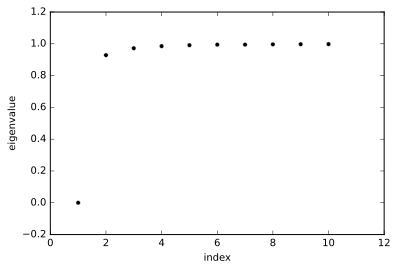

In [9]:
C.PlotEigengap()

Here we see big jumps between 1 and 2, and a smaller gap between 2 and 3. For many datasets, you may want to consider other factors, e.g. choosing a minimum number of clusters, whether or not the eigengap reflects this.

Here we have chosen 3 as the optimal number of clusters, given our prior knowledge about this benchmark dataset.

In [10]:
C.Cluster(n_clusters=3)

performing spectral clustering on dot products...
    done.


The clustering results are stored in `C@clusters`. The cell similarity matrix can be visualized in two dimensions by plotting points using two eigenvectors.

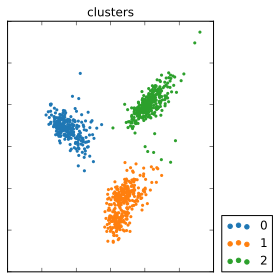

In [11]:
C.PlotEmbedding()

As we see, cells fall into three clusters which separate along the first two dimensions.

## Subsampling data

It's not always necessary to standardize sequencing depth across cells in order to make useful comparisons. However there are certain comparisons where we might expect differences in sequencing depth to obscure biological differences, for example, when calculating differential gene expression across cells. 

One method of standardizing sequencing depth is to subsample counts to an equivalent number for all cells. Since the scRNA-seq counting process stops at an arbitrary point, we can randomly subsample from our observations per cell to stop the process at a specific number of our choosing.

Here we do this with the function `C.Subsample()`. To subsample to the minimum number of total counts across cells, use `cell_counts='min'`, otherwise use a number of counts larger than the minimum value.

In [12]:
C.Subsample(cell_counts='min')
C.subsample

subsampling all cells to a standard sequencing depth of 40152


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

There are also cases where we might expect differences in the magnitude of expression across genes to obscure biological variation. The dot product is calculated by summing the product of each gene, meaning genes with substantially larger count values will contribute more to the dot product than genes with smaller values. This feature of the dot product can be useful for emphasizing genes with the largest dynamic range of counts, given that expression variance scales with magnitude. But when highly expressed genes do not contain informative biological signal, this variance might drown out signal from genes with lower expression magnitudes.

A count-based approach for tuning down the signal of highly expressed genes is to limit their total counts by randomly subsampling observations per gene. We can accomplish this by establishing a threshold for total counts and subsampling that number of observations from any gene vector that exceeds that threshold.

Here we do this with the function `C.Subsample(gene_counts=[maximum])`. An example maximum value might be equal to 10x the number of cells (rows in the count matrix).

In [13]:
# the following will overwrite our previous subsampled matrix 
C.Subsample(gene_counts=10*C.counts.shape[0]) 

# to subsample both genes and cells, 
# use gene_counts and cell_counts in the same function. 
# Genes will be subsampled first.

# C <- Subsample(C,gene_counts=10*C.counts.shape[0],cell_counts='min')

subsampling 1592 genes to a max total counts of 9250


## Subsetting data

An alternative approach to subsampling is to focus on only subsets of genes or cells when making comparisons. Here we filter the count matrix to only certain cells and genes using `C.SubsetCells()` and `C.SubsetGenes()`.

With `countland`, such data filtering may not be necessary or helpful, so we don't recommend any filtering scheme by default.

In [14]:
filter_cells = np.array(C.cell_scores['n_features'] < 8500) # cells with fewer than 8,500 unique genes observed
C.SubsetCells(filter_cells,remove_empty=False)

Number of genes: 29212
Number of cells: 463


In [15]:
filter_genes = (np.sum(C.counts,0) > 100) # genes that were observed
C.SubsetGenes(filter_genes,remove_empty=False)

Number of genes: 11569
Number of cells: 463


The original count matrix can be restored at any time.

In [16]:
C.RestoreCounts()

Number of genes: 29212
Number of cells: 925


## Identify marker genes

The ideal marker gene for a cluster of cells can be definedas the gene that is most specifically expressed in cluster cells, or as the gene with the highest differential expression between cells in the cluster and all other cells.

A count-based approach for identifying marker genes by specificity is to count the number of cells with non-zero observations for each gene, and then calculating the difference between the fraction of these cells in a cluster versus the fraction that are not (here with `method='prop-zero'`). The ideal marker gene would return a value of one, indicating it was expressed in all cluster cells and no others.

In [17]:
C.RankMarkerGenes(method='prop-zero',subsample=False)
gdf = C.marker_genes.loc[(C.marker_genes['cluster_label'] == 1)]
gdf

,diff. proportion zero,rank,gene index,gene names,cluster_label
29209,0.908334,1,29209,ENSG00000276345,1
20101,0.893986,2,20101,ENSG00000258949,1
10929,0.849809,3,10929,ENSG00000237268,1
27900,0.844985,4,27900,ENSG00000129991,1
26020,0.797944,5,26020,ENSG00000100979,1
3650,0.788872,6,3650,ENSG00000186281,1
10885,0.787818,7,10885,ENSG00000164744,1
24455,0.775748,8,24455,ENSG00000262902,1
28254,0.766979,9,28254,ENSG00000185686,1
20760,0.742432,10,20760,ENSG00000156414,1


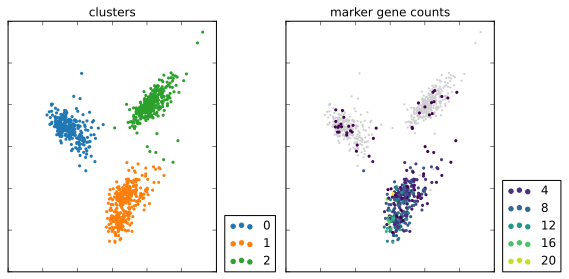

In [18]:
gene_index = gdf.loc[(gdf['cluster_label'] == 1) & (gdf['rank'] == 1)]['gene index'].values
C.PlotMarker(gene_index)

This plot shows the counts for the top marker gene, defined by specificity, for cluster 1.

Alternatively we can defined the top marker gene by differential expression (here with `method='rank-sums'`). This is assessed using rank-sums tests. Counts for a given gene are ranked between cluster and non-cluster cells, the ranks for each group are summed, and a test statistic is calculated. This statistic is used to test the hypothesis that observations from cluster cells are larger than those from non-cluster cells.

Because heterogeneity in count depth can influence the magnitude of expression for individual gene, subsampling to a standard sequencing depth prior to calculating differential gene expression is recommended.

**Note this can take some time.**

In [19]:
C.Subsample(cell_counts="min")
C.RankMarkerGenes(method='rank-sums',subsample=True)
gdf = C.marker_genes.loc[(C.marker_genes['cluster_label'] == 1)]
gdf

subsampling all cells to a standard sequencing depth of 40152


,test-statistic,p-value,adjusted-p-value,significant diff.,rank,gene index,gene names,cluster_label
24455,193041.5,4.175227e-171,1.219667e-166,True,1,24455,ENSG00000262902,1
19921,192821.0,7.444146e-146,1.087292e-141,True,2,19921,ENSG00000100867,1
23460,192808.5,1.486061e-137,1.085270e-133,True,3,23460,ENSG00000170291,1
9866,191500.5,2.785496e-131,1.017124e-127,True,4,9866,ENSG00000203875,1
28423,190201.0,1.073616e-129,3.484719e-126,True,5,28423,ENSG00000198832,1
26308,189994.5,4.562130e-127,1.211536e-123,True,6,26308,ENSG00000115268,1
26290,186871.5,7.087838e-119,1.592692e-115,True,7,26290,ENSG00000167468,1
10064,186339.0,4.090623e-133,1.707075e-129,True,8,10064,ENSG00000230202,1
28520,186185.0,5.025094e-117,8.634885e-114,True,9,28520,ENSG00000100097,1
28061,186155.5,5.984310e-117,9.711871e-114,True,10,28061,ENSG00000083845,1


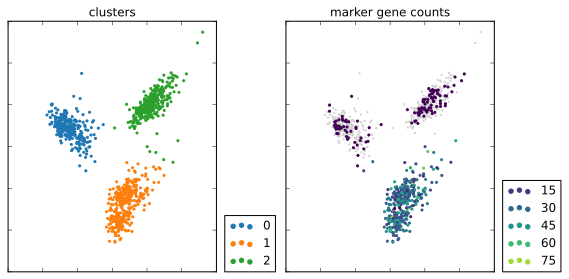

In [20]:
gene_index = gdf.loc[(gdf['cluster_label'] == 1) & (gdf['rank'] == 1)]['gene index'].values 
C.PlotMarker(gene_index)

This plot shows the counts for the top marker gene, defined by differential gene expression, for cluster 1.